In [1]:
import numpy as np
import torch
import joblib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from mnist_classifier import MnistClassifier
import matplotlib.pyplot as plt

# Loading MNIST dataset
mnist = fetch_openml("mnist_784", version=1)
X, y = mnist.data, mnist.target.astype(int)

# Train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler() # Scaling data fot RF and FFNN
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_nn = X_train.values / 255.0  # Train normalization
X_test_nn = X_test.values / 255.0  # Test normalization

# Transform to numpy our data and to int data
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.astype(int)
y_test = y_test.astype(int)

In [2]:
models = {}
for model_type in ["rf", "nn", "cnn"]:
    print(f"Training model: {model_type.upper()}")

    clf = MnistClassifier(algorithm=model_type)

    if model_type == "cnn":
        # Data for CNN
        X_train_tensor = torch.tensor(X_train_nn, dtype=torch.float32).view(-1, 1, 28, 28)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long)

        clf.train(X_train_tensor, y_train_tensor, epochs=5)
    else:
        clf.train(X_train_scaled, y_train)

    models[model_type] = clf
    print(f"Model {model_type.upper()} trained.\n")


Training model: RF
Training Random Forest
Model RF trained.

Training model: NN
Initializing Feed-Forward Neural Network
FFNN initialized
X_train shape: torch.Size([56000, 784]), y_train shape: torch.Size([56000])
Epoch 1 of 10, Loss: 223.0144
Epoch 2 of 10, Loss: 90.6492
Epoch 3 of 10, Loss: 57.4234
Epoch 4 of 10, Loss: 43.5406
Epoch 5 of 10, Loss: 33.4674
Epoch 6 of 10, Loss: 27.1514
Epoch 7 of 10, Loss: 21.6134
Epoch 8 of 10, Loss: 21.6864
Epoch 9 of 10, Loss: 25.9286
Epoch 10 of 10, Loss: 16.1975
Model NN trained.

Training model: CNN
Epoch 1 of 5, Loss: 161.6584
Epoch 2 of 5, Loss: 46.0238
Epoch 3 of 5, Loss: 31.0044
Epoch 4 of 5, Loss: 22.0142
Epoch 5 of 5, Loss: 18.0405
Model CNN trained.



In [3]:
accuracies = {}

for model_type, clf in models.items():
    print(f"Testing of model: {model_type.upper()}")

    
    if model_type == "cnn":
        X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32).view(-1, 1, 28, 28) # Transform test data to torch (number of colors, image size)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long) # # Transform test data to torch (int)
        preds = clf.predict(X_test_tensor) # prediction number (0-9)
        accuracy = np.mean(preds == y_test_tensor.numpy()) # % of right answers (True/False)

    elif model_type == "nn":
        X_test_tensor = torch.tensor(X_test_nn, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.long)
        preds = clf.predict(X_test_tensor)
        accuracy = np.mean(preds == y_test_tensor.numpy())

    else:
        preds = clf.predict(X_test_scaled)
        accuracy = np.mean(preds == y_test)

    accuracies[model_type.upper()] = accuracy
    print(f"Accuracy of {model_type.upper()}: {accuracy:.4f}\n")




Testing of model: RF
Predicting Random Forest
Accuracy of RF: 0.9674

Testing of model: NN
Accuracy of NN: 0.8981

Testing of model: CNN
Accuracy of CNN: 0.9875



Final values:
RF: 0.9674
NN: 0.8981
CNN: 0.9875


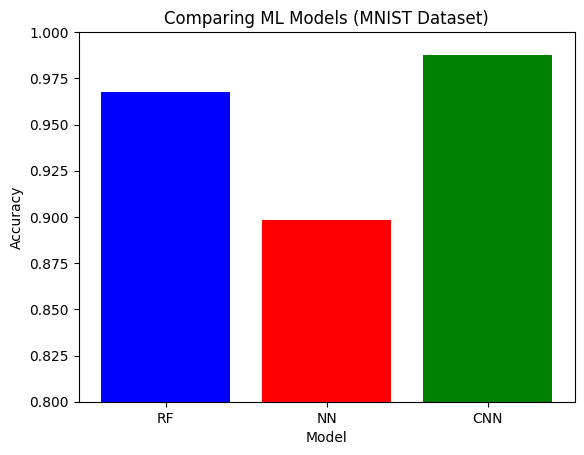

In [4]:
# Plot of compasion ML Models
accuracy_keys = list(accuracies.keys())
accuracy_values = list(accuracies.values())

print("Final values:")
for key, value in zip(accuracy_keys, accuracy_values):
    print(f"{key}: {value:.4f}")

plt.bar(accuracy_keys, accuracy_values, color=['blue', 'red', 'green'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Comparing ML Models (MNIST Dataset)")
plt.ylim(0.80, 1.0)
plt.show()


Using model: CNN


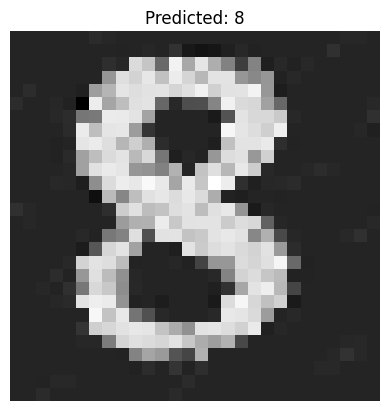

Predicted number: 8


In [5]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Using gray color
    img = cv2.resize(img, (28, 28)) 
    
    # Channging color if white
    if np.mean(img) > 128:
        img = 255 - img

    img = img.astype(np.float32) / 255.0  # Normalization
    
    img_cnn = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # process for CNN
    img_flat = img.flatten().reshape(1, -1)  # For RF and NN
    
    return img_cnn, img_flat, img

def predict_image(image_path, model_type="cnn"):
    print(f"Using model: {model_type.upper()}")

    clf = models[model_type]  
    img_cnn, img_flat, img_vis = preprocess_image(image_path)

    if model_type == "cnn":
        pred = clf.predict(img_cnn)
    else:
        pred = clf.predict(img_flat)

    # Plotting image with digit
    plt.imshow(img_vis, cmap="gray")
    plt.title(f"Predicted: {pred[0]}")
    plt.axis("off")
    plt.show()

    return pred[0]

# Predicting number by image
image_path = "images/ei.png"  
model_type = "cnn" 
predicted_digit = predict_image(image_path, model_type)
print(f"Predicted number: {predicted_digit}")
